# Final Project: Machine Learning (ML) For Medical Diagnosis

Author: [Chuan Qin](https://github.com/Playchildren), Supervisor: [Associate Professor. Sergiy Bogomolov](https://www.sergiybogomolov.com/) and [Dr. Paulius Stankaitis](http://stankaitis.uk/)

### In this project, we are going to use some popular CNN models to classify medical images of human lungs.
The [Dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database) from kaggle include 10000 images for each different classes ["Normal", "COVID", "Lung Opacity", "Viral Pneumonia"]

The python libraries used in this project are: </br>
python == 3.9 </br>
pytorch == 1.11.0 </br>
pandas == 1.2.4 </br>
numpy == 1.16.6 </br>
matplotlib == 3.4.3 </br>
opencv == 4.5.5 </br>
torchsummary == 1.5.1 </br>
torchvision == 0.12.0 </br>
tqdm == 4.64.0 </br>

#### First of All, Let's do some Data Pre-processing

In [1]:
import os

from torch.utils.data import DataLoader, Dataset

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, utils, datasets
from PIL import Image
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

E:\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Since the RGB images in the dataset have the same values in the three channels, 
# in order to simplify the model calculation process, 
# we can only retain the pixel values of one channel of the image.

data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(224), # To fit popular models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507], std=[0.245]),
    # transforms.Normalize(mean=[0.507, 0.507, 0.507], std=[0.245,0.245,0.245]),
])

# If mean and std are not calculated by using our dataset
# it can be replaced with ImageNet's mean and std which is useful for most image classification tasks
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [3]:
train_dataset = datasets.ImageFolder(root="C:\\Users\\playc\\final_project\\train",
                              transform=data_transform)

In [4]:
# View the image features after processing

image, label = train_dataset[0]
print(image.shape)
print(label)
image

torch.Size([1, 224, 224])
0


tensor([[[-0.2126, -1.8133, -2.0694,  ..., -2.0534, -1.9093, -0.8049],
         [-1.5572, -2.0054, -2.0694,  ..., -2.0534, -2.0214, -1.7493],
         [-2.0374, -2.0694, -2.0694,  ..., -2.0534, -1.9894, -1.8293],
         ...,
         [-1.0290, -1.0770, -0.8369,  ..., -2.0374, -1.9894, -1.8773],
         [-0.7248, -0.9489, -0.7409,  ..., -2.0534, -1.9093, -1.3651],
         [-0.0846, -0.7729, -0.6768,  ..., -2.0694, -1.7493, -0.3087]]])

In [5]:
# print the first image in out dataset

image, label = train_dataset[0]
print(label)
image

0


tensor([[[-0.2126, -1.8133, -2.0694,  ..., -2.0534, -1.9093, -0.8049],
         [-1.5572, -2.0054, -2.0694,  ..., -2.0534, -2.0214, -1.7493],
         [-2.0374, -2.0694, -2.0694,  ..., -2.0534, -1.9894, -1.8293],
         ...,
         [-1.0290, -1.0770, -0.8369,  ..., -2.0374, -1.9894, -1.8773],
         [-0.7248, -0.9489, -0.7409,  ..., -2.0534, -1.9093, -1.3651],
         [-0.0846, -0.7729, -0.6768,  ..., -2.0694, -1.7493, -0.3087]]])

In [6]:
train_datasets_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


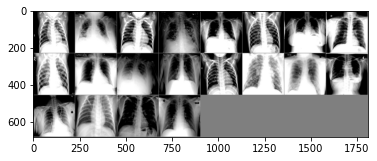

['Not Covid', 'Covid', 'Not Covid', 'Not Covid', 'Not Covid', 'Not Covid', 'Not Covid', 'Covid', 'Not Covid', 'Covid', 'Not Covid', 'Covid', 'Not Covid', 'Covid', 'Not Covid', 'Not Covid', 'Not Covid', 'Not Covid', 'Covid', 'Covid']


In [7]:
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_datasets_loader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images))

print("".join('%s' %["Covid" if labels[i].item() == 0 else "Not Covid" for i in range(20)]))

In [8]:
test_dataset = datasets.ImageFolder(root="C:\\Users\\playc\\final_project\\test",
                              transform=data_transform)
test_datasets_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [9]:
print('The length of trainset:', train_dataset.__len__())
print('The length of testset:', test_dataset.__len__())

The length of trainset: 2800
The length of testset: 1200


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

E:\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# use GPU for training, if GPU is not available, use CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Train on normal CNN model

In [17]:
class SimpleCNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(SimpleCNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 *56 *56, 4)
        
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [19]:
# print the structure of model

from torchsummary import summary
from torchvision import models
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             416
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]          12,832
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                    [-1, 4]         401,412
Total params: 414,660
Trainable params: 414,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 11.48
Params size (MB): 1.58
Estimated Total Size (MB): 13.26
----------------------------------------------------------------


In [18]:
from tqdm import tqdm

model = SimpleCNN(out_1=16, out_2=32)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model

n_epochs=20
cnn_cost_list=[]
cnn_accuracy_list=[]
N_test=len(test_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in tqdm(train_datasets_loader):
            x=x.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost = loss.data
            COST += float(cost.to("cpu"))
            # COST += loss.data

        
        cnn_cost_list.append(COST)
        correct=0
        
        #perform a prediction on the test data  
        for x_test, y_test in test_datasets_loader:
            x_test= x_test.to(device)
            y_test= y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        cnn_accuracy_list.append(accuracy)
        
        print("epoch" + str(epoch) + ": cost:" + str(cnn_cost_list[epoch]) + " acc:" + str(cnn_accuracy_list[epoch]))

In [20]:
train_model(n_epochs)

100%|██████████| 140/140 [00:09<00:00, 14.68it/s]


epoch0: cost:118.3395476937294 acc:0.815


100%|██████████| 140/140 [00:09<00:00, 14.26it/s]


epoch1: cost:72.54553462564945 acc:0.815


100%|██████████| 140/140 [00:09<00:00, 14.31it/s]


epoch2: cost:56.08336503058672 acc:0.865


100%|██████████| 140/140 [00:09<00:00, 14.15it/s]


epoch3: cost:46.20487367361784 acc:0.8883333333333333


100%|██████████| 140/140 [00:10<00:00, 13.80it/s]


epoch4: cost:39.33569862693548 acc:0.8741666666666666


100%|██████████| 140/140 [00:10<00:00, 13.81it/s]


epoch5: cost:29.47098110988736 acc:0.8883333333333333


100%|██████████| 140/140 [00:10<00:00, 13.88it/s]


epoch6: cost:24.466822437942028 acc:0.8666666666666667


100%|██████████| 140/140 [00:10<00:00, 13.53it/s]


epoch7: cost:18.64749302342534 acc:0.8866666666666667


100%|██████████| 140/140 [00:10<00:00, 13.63it/s]


epoch8: cost:14.970237552653998 acc:0.8883333333333333


100%|██████████| 140/140 [00:10<00:00, 13.96it/s]


epoch9: cost:19.90110917761922 acc:0.8733333333333333


100%|██████████| 140/140 [00:09<00:00, 14.04it/s]


epoch10: cost:13.33422116190195 acc:0.8608333333333333


100%|██████████| 140/140 [00:10<00:00, 13.84it/s]


epoch11: cost:8.386196865234524 acc:0.8891666666666667


100%|██████████| 140/140 [00:09<00:00, 14.08it/s]


epoch12: cost:4.515373019268736 acc:0.8883333333333333


100%|██████████| 140/140 [00:10<00:00, 13.71it/s]


epoch13: cost:3.3270547188585624 acc:0.89


100%|██████████| 140/140 [00:10<00:00, 13.90it/s]


epoch14: cost:2.4089059130637906 acc:0.8916666666666667


100%|██████████| 140/140 [00:10<00:00, 13.94it/s]


epoch15: cost:1.7309291893034242 acc:0.8833333333333333


100%|██████████| 140/140 [00:10<00:00, 13.80it/s]


epoch16: cost:1.2740944167599082 acc:0.8825


100%|██████████| 140/140 [00:10<00:00, 13.79it/s]


epoch17: cost:0.9630548307031859 acc:0.8783333333333333


100%|██████████| 140/140 [00:10<00:00, 13.88it/s]


epoch18: cost:0.9953899159445427 acc:0.8908333333333334


100%|██████████| 140/140 [00:10<00:00, 13.86it/s]


epoch19: cost:0.6776483451249078 acc:0.8875


In [21]:
# clear the cache
torch.cuda.empty_cache()

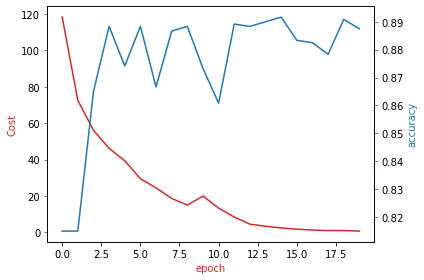

In [22]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cnn_cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(cnn_accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [23]:
torch.save(model.state_dict(), "final_project.pth")

In [24]:
model.load_state_dict(torch.load("final_project.pth"))
model.eval()

SimpleCNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=4, bias=True)
)

In [8]:
def predict(model, img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img = data_transform(img)
    img = img.view(1, 1, 224, 224)
    img = img.to(device)
    output = model(img)
    print(output)
    _, prediction = torch.max(output, 1)
    prediction = prediction[0].item()
    print(prediction)
    return

In [27]:
from PIL import Image
img = Image.open("C:\\Users\\playc\\final_project\\train\\2\\Normal-112.PNG")

predict(model, img)

tensor([[ -5.6760, -12.8954,  18.3250,   0.5878]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
2


## Train on VGG19 model

In [5]:
import torch.nn as nn

class VGG19(nn.Module):

    # initialize model
    def __init__(self, img_size=224, input_channel=1, num_class=4):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # default parameter：nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv14 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv16 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.fc17 = nn.Sequential(
            nn.Linear(int(512 * img_size * img_size / 32 / 32), 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        self.fc18 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        self.fc19 = nn.Sequential(
            nn.Linear(4096, num_class)
        )

        self.conv_list = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.conv6, self.conv7,
                          self.conv8, self.conv9, self.conv10, self.conv11, self.conv12, self.conv13, self.conv14,
                          self.conv15, self.conv16]

        self.fc_list = [self.fc17, self.fc18, self.fc19]

        print("VGG19 Model Initialize Successfully!")

    # forward
    def forward(self, x):
        for conv in self.conv_list:    # 16 CONV
            x = conv(x)
        output = x.view(x.size()[0], -1)
        for fc in self.fc_list:        # 3 FC
            output = fc(output)
        return output

In [30]:
from torchsummary import summary
from torchvision import models
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [29]:
from tqdm import tqdm

model = VGG19()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model

n_epochs=20
vgg_cost_list=[]
vgg_accuracy_list=[]
N_test=len(test_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in tqdm(train_datasets_loader):
            x=x.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost = loss.data
            COST += float(cost.to("cpu"))
            # COST += loss.data
            
        vgg_cost_list.append(COST)
        correct=0
        
        #perform a prediction on the test data  
        for x_test, y_test in test_datasets_loader:
            x_test= x_test.to(device)
            y_test= y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        vgg_accuracy_list.append(accuracy)
        
        print("epoch" + str(epoch) + ": cost:" + str(vgg_cost_list[epoch]) + " acc:" + str(vgg_accuracy_list[epoch]))

VGG19 Model Initialize Successfully!


In [31]:
train_model(n_epochs)

100%|██████████| 140/140 [01:03<00:00,  2.19it/s]


epoch0: cost:111.70177760720253 acc:0.6925


100%|██████████| 140/140 [01:14<00:00,  1.89it/s]


epoch1: cost:66.82522684335709 acc:0.8516666666666667


100%|██████████| 140/140 [01:15<00:00,  1.85it/s]


epoch2: cost:54.58245063573122 acc:0.8891666666666667


100%|██████████| 140/140 [01:13<00:00,  1.89it/s]


epoch3: cost:42.845778077840805 acc:0.8858333333333334


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


epoch4: cost:36.1439164057374 acc:0.91


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


epoch5: cost:31.215447479858994 acc:0.8858333333333334


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


epoch6: cost:24.941825893707573 acc:0.9283333333333333


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


epoch7: cost:20.549653036519885 acc:0.9083333333333333


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


epoch8: cost:18.622680802363902 acc:0.93


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


epoch9: cost:13.56595184886828 acc:0.9233333333333333


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


epoch10: cost:21.979338485281914 acc:0.9033333333333333


100%|██████████| 140/140 [01:11<00:00,  1.95it/s]


epoch11: cost:11.709633139427751 acc:0.9316666666666666


100%|██████████| 140/140 [01:12<00:00,  1.94it/s]


epoch12: cost:9.892491159727797 acc:0.9266666666666666


100%|██████████| 140/140 [01:13<00:00,  1.91it/s]


epoch13: cost:9.696566903381608 acc:0.9283333333333333


100%|██████████| 140/140 [01:12<00:00,  1.93it/s]


epoch14: cost:5.562837812525686 acc:0.9325


100%|██████████| 140/140 [01:12<00:00,  1.92it/s]


epoch15: cost:7.9964306680631125 acc:0.9066666666666666


100%|██████████| 140/140 [01:11<00:00,  1.97it/s]


epoch16: cost:9.017396007635398 acc:0.9283333333333333


100%|██████████| 140/140 [01:10<00:00,  1.97it/s]


epoch17: cost:3.5110566942603327 acc:0.9125


100%|██████████| 140/140 [01:12<00:00,  1.92it/s]


epoch18: cost:4.176317465302418 acc:0.9325


100%|██████████| 140/140 [01:11<00:00,  1.97it/s]


epoch19: cost:5.7170935480280605 acc:0.925


In [3]:
# clear the cache
torch.cuda.empty_cache()

In [33]:
torch.save(model.state_dict(), "vgg19_final_project.pth")

In [17]:
model = VGG19()
model.to(device)
model.load_state_dict(torch.load("vgg19_final_project.pth"))
model.eval()

VGG19 Model Initialize Successfully!


VGG19(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2,

In [18]:
from PIL import Image
img = Image.open("C:\\Users\\playc\\final_project\\train\\0\\COVID-200.PNG")

predict(model, img)

tensor([[18.5387, -4.3679, -7.8071, -5.4636]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0


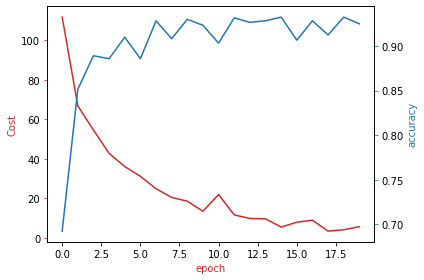

In [36]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(vgg_cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(vgg_accuracy_list, color=color) 
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [19]:
predict(model, img)

tensor([[18.5387, -4.3679, -7.8071, -5.4636]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
0
